In [1]:
%load_ext autoreload
%autoreload 2

from typing import List

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from cost_structures import CostStructure
from inventory_states import NonPerishableInventoryState

from policies.abstract_inventory_policy import AbstractInventoryPolicy
from policies.target_level_ogd import TargetLevelOGD
from policies.optimal_lost_sales_policy import OptimalLostSalesPolicy
from policies.constant_order_quantity import ConstantOrderQuantity
from policies.constant_base_stock import ConstantBaseStock

SEED = 0
np.random.seed(SEED)

Inventory state initialization

In [2]:
nb_products = 1
lead_times = np.zeros(nb_products,dtype=int)
state = NonPerishableInventoryState(nb_products,lead_times,"LOST_SALES")

Demand generator definition

In [3]:
upper_bound = 100
demand_rvs = [scipy.stats.beta(a=0.1, b=0.5, scale=100) for k in range(nb_products)]
def demands_generator() :
    yield np.array([demand_rvs[k].rvs() for k in range(nb_products)])

Costs initialization

In [4]:
fixed_costs = np.zeros(nb_products)
purchase_costs = np.zeros(nb_products)
holding_costs = np.random.lognormal(0,size=nb_products)
stockout_costs = np.random.lognormal(2,size=nb_products)
cost_structure = CostStructure(nb_products,fixed_costs,purchase_costs,holding_costs,stockout_costs)
print("fixed_costs:{}\npurchase_costs:{}\nholding_costs:{}\nstockout_costs:{}".format(fixed_costs, purchase_costs, holding_costs, stockout_costs))

fixed_costs:[0.]
purchase_costs:[0.]
holding_costs:[5.83603919]
stockout_costs:[11.02490945]


Policies initialization

In [5]:
initial_base_stock = [
    [upper_bound/2],
    [upper_bound/2],
    [upper_bound/2]
]

learning_rates = [
    lambda t : 1/t,
    lambda t : 1/np.sqrt(t),
    lambda t : 1/np.sqrt(nb_periods)
]

policies : List[AbstractInventoryPolicy] = [
    TargetLevelOGD(nb_products,initial_base_stock[i],[100],learning_rates[i],cost_structure)
    for i in range(len(learning_rates))
] + [
    OptimalLostSalesPolicy(nb_products, purchase_costs, holding_costs, stockout_costs, discount_factor=1.0, demand_quantile_functions=[demand_rvs[k].ppf for k in range(nb_products)]),
    ConstantBaseStock([demand_rvs[k].mean() for k in range(nb_products)]),
]

policy_names = [
    "TargetLevelOGD 1/t",
    "TargetLevelOGD 1/sqrt(t)",
    "TargetLevelOGD 1/sqrt(T)",
    "OptimalUnconstrained",
    "MeanDemandBaseStock"
]

Optimal unconstrainted base-stock level: [4.84003223]


In [6]:
nb_periods = 10000
state.reset()
cost_structure.reset()
for policy_id in tqdm(range(len(policies))) : 
    for t in tqdm(range(1,nb_periods+1)) :
        order_quantities = policies[policy_id].get_order_quantity(t,state)
        demands = next(demands_generator())
        state.step(t,order_quantities,demands)
        cost_structure.incur_cost(t,state,order_quantities)
    cost_structure.save_history_as_csv("costs_{}.csv".format(policy_id))
    state.save_movements_as_csv("movements_{}.csv".format(policy_id))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Results

Aggregated costs

In [20]:
for policy_id in range(len(policies)) :
    print("\nPolicy {}".format(policy_names[policy_id]))
    #print(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum())
    print("Total cost: {:e}".format(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum().sum()))


Policy TargetLevelOGD 1/t
Total cost: 1.839184e+06

Policy TargetLevelOGD 1/sqrt(t)
Total cost: 1.767372e+06

Policy TargetLevelOGD 1/sqrt(T)
Total cost: 1.877901e+06

Policy OptimalUnconstrained
Total cost: 1.755510e+06

Policy MeanDemandBaseStock
Total cost: 1.914994e+06


Cumulative total cost

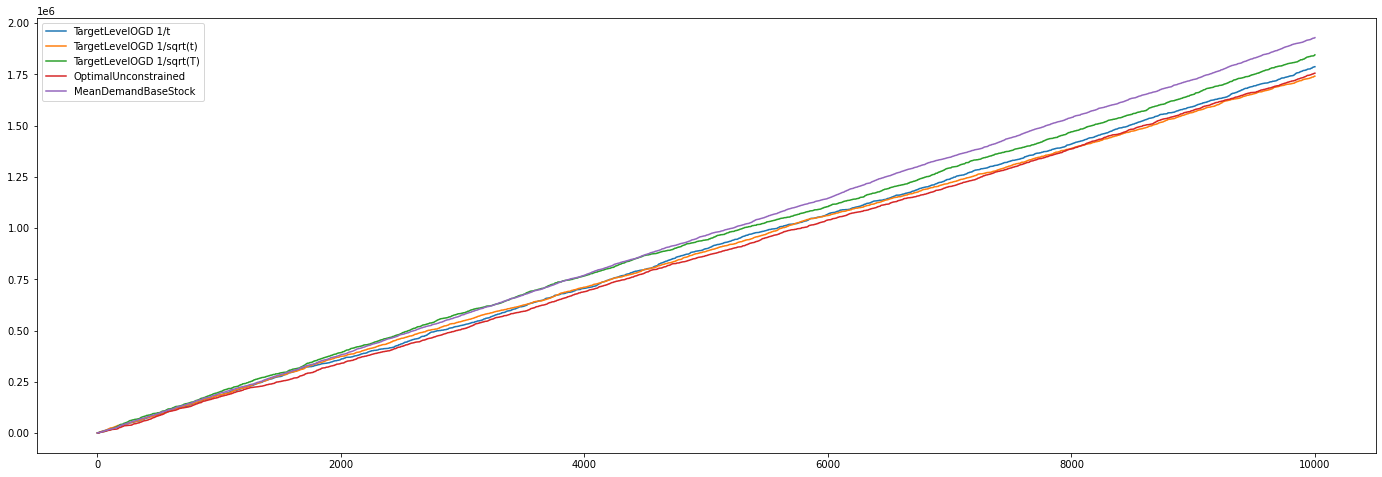

In [19]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(
        pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum(),label=policy_names[policy_id]
    )
plt.legend()
plt.show()

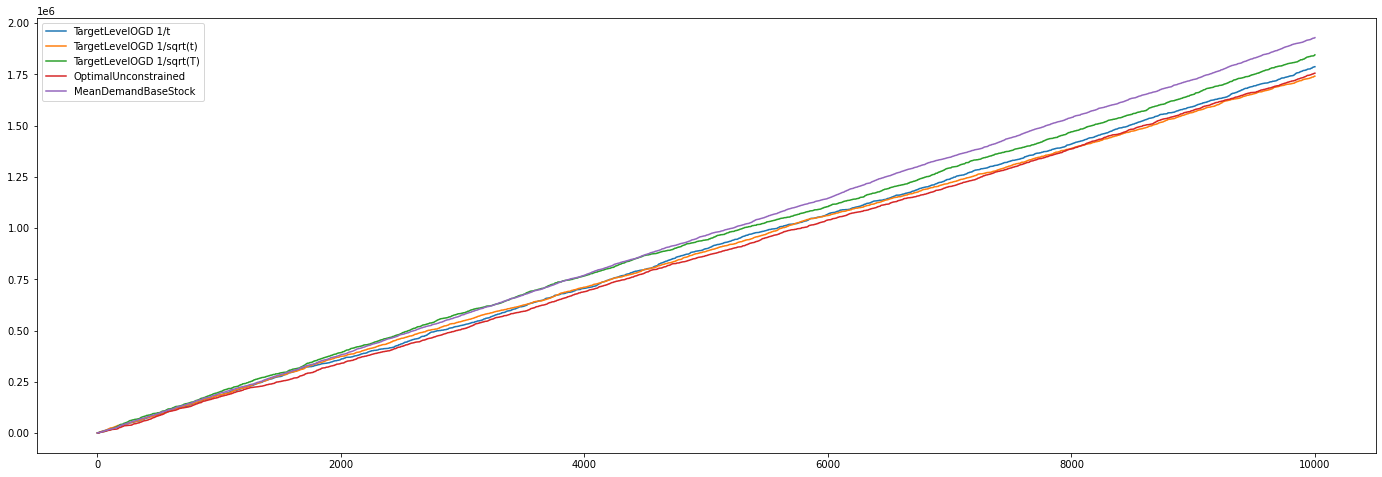

In [9]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

Cumulative holding cost

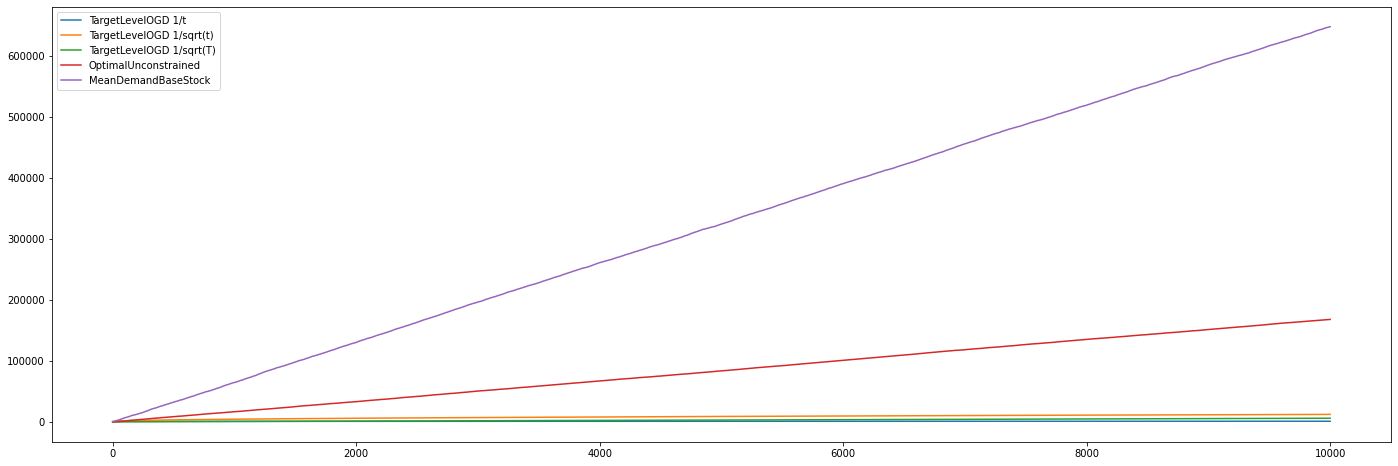

In [10]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["holding_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

Cumulative stockout cost

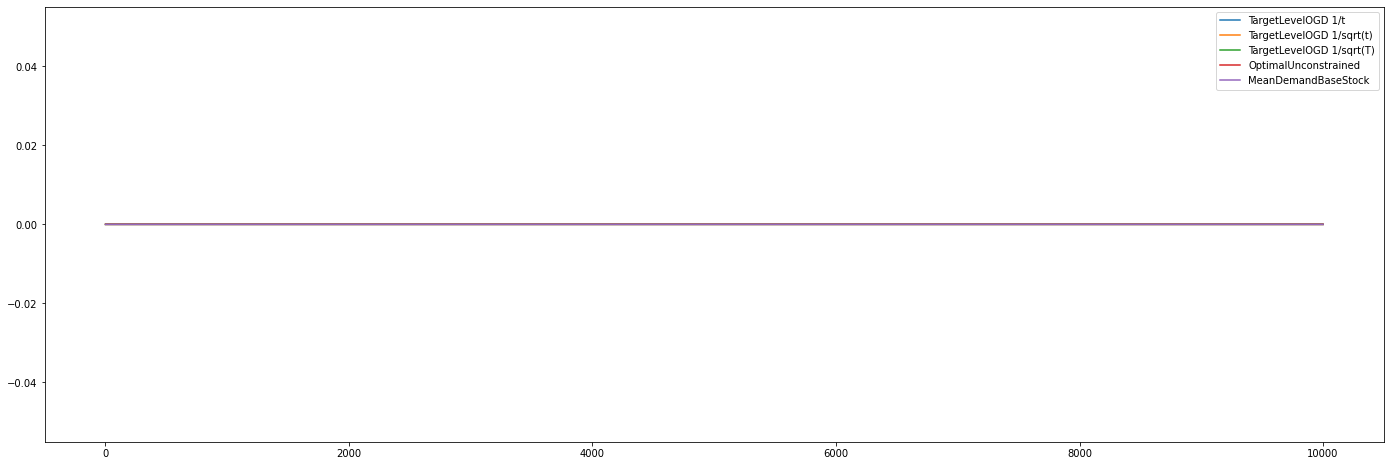

In [11]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["purchase_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()